# MLP Autoencoder

In [1]:
import os
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  ## just for ignore DeprcationWarning message
print("Current version [%s]" %(tf.__version__))
print("Packages Loaded")

Current version [1.3.1]
Packages Loaded


### Configurations

In [2]:
# Dataset Configurations
tf.app.flags.DEFINE_integer('img_size', 28, """Image size of MNIST dataset""")

# Network Configurations
tf.app.flags.DEFINE_integer('batch_size', 100, """Number of images to process in a batch""")
tf.app.flags.DEFINE_float('l1_ratio', 0.5, """Ratio of level1""")
tf.app.flags.DEFINE_float('l2_ratio', 0.5, """Ratio of level2""")

# Optimization Configurations
tf.app.flags.DEFINE_float('lr', 0.001, """Learning rate""")

# Training Configurations
tf.app.flags.DEFINE_integer('training_epochs', 200, """Number of epochs to run""")
tf.app.flags.DEFINE_integer('display_step', 5, """Number of iterations to display training output""")
tf.app.flags.DEFINE_integer('save_step', 5, """Number of interations to save checkpoint""")
tf.app.flags.DEFINE_integer('save_max', 5, """Number of checkpoints to remain""")


# Save Configurations
tf.app.flags.DEFINE_string('nets', './nets', """Directory where to write the checkpoints""")
tf.app.flags.DEFINE_string('outputs', './outputs', """Directory where to save the output images""")
tf.app.flags.DEFINE_string('tboard', './tensorboard', """Directory where to save the tensorboard logs""")


FLAGS = tf.app.flags.FLAGS
print("FLAGS READY")

FLAGS READY


### GPU control

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True

### Load Data

In [4]:
mnist = input_data.read_data_sets('../../data/', one_hot=True)
train_img = mnist.train.images
train_label = mnist.train.labels
test_img = mnist.test.images
test_label = mnist.test.labels
print("MNIST ready")

Extracting ../../data/train-images-idx3-ubyte.gz
Extracting ../../data/train-labels-idx1-ubyte.gz
Extracting ../../data/t10k-images-idx3-ubyte.gz
Extracting ../../data/t10k-labels-idx1-ubyte.gz
MNIST ready


### Generating random noise mask

In [13]:
def noise_mask(prob=0.5):
    mask = np.zeros([FLAGS.img_size, FLAGS.img_size])
    rd = np.random.random()
    if rd > prob:
        # threshold of the size of masks
        uthd = FLAGS.img_size    
        lthd = 0     
        # mask size should be beween 14x14, 5x5
        while(uthd>14 or lthd<5):
            ver1 = np.random.random_integers(0, FLAGS.img_size-1, size= 2)   # vertex1
            ver2 = np.random.random_integers(0, FLAGS.img_size-1, size= 2)    # vertex2
            uthd = np.maximum(np.abs(ver1[0]-ver2[0]), np.abs(ver1[1]-ver2[1]))    # upperbound
            lthd = np.minimum(np.abs(ver1[0]-ver2[0]), np.abs(ver1[1]-ver2[1]))    # lowerbound
        xmin = np.minimum(ver1[0], ver2[0])    # left x value
        xmax = np.maximum(ver1[0], ver2[0])    # right x value
        ymin = np.minimum(ver1[1], ver2[1])    # top y value
        ymax = np.maximum(ver1[1], ver2[1])    # bottom y value
        noise = np.random.random((xmax-xmin+1, ymax-ymin+1))    # random sample in [0,1]
        mask[xmin:xmax+1, ymin:ymax+1] = noise    # noise mask with location
        mask_meta = [xmin, xmax, ymin, ymax, noise, mask]
    mask = np.reshape(mask, [-1])
    return mask

def noise_batch(batch_num):
    # make random noise batch
    mask_batch = np.zeros([batch_num, FLAGS.img_size*FLAGS.img_size])
    for i in range(batch_num):
        mask_batch[i,:] = noise_mask()
    return mask_batch

### Occlusion generation

In [6]:
def occl(target, disturb):
    mask = (disturb==0).astype(float)
    masked_target = np.multiply(target, mask)
    crpt = np.add(masked_target, disturb)
    return crpt

### Nested MLP

In [7]:
def _nested_mlp(l1, l2_s, l2, out_channel, name, stddev=0.1, is_init=False, is_last=False):
    l1_shape = l1.get_shape()[1]
    l2_shape = l2.get_shape()[1]
    l2_s_shape = l2_s.get_shape()[1]
    
    if is_init:
        # input is the input image
        with tf.device('/CPU:0'):
            with tf.variable_scope('level1'):
                with tf.variable_scope(name):
                    l1_weights = tf.get_variable('weights', 
                                                 [l1_shape, out_channel*FLAGS.l1_ratio], 
                                                 tf.float32, 
                                                 initializer=tf.random_normal_initializer(stddev=stddev))
                    l1_biases = tf.get_variable('biases', 
                                                [out_channel*FLAGS.l1_ratio],
                                                tf.float32, 
                                                initializer=tf.random_normal_initializer(stddev=stddev))
            with tf.variable_scope('level2'):
                with tf.variable_scope(name):
                    l2_s_weights = tf.get_variable('weights_shell', 
                                                 [l2_s_shape, out_channel*FLAGS.l2_ratio], 
                                                 tf.float32, 
                                                 initializer=tf.random_normal_initializer(stddev=stddev))
                    l2_s_biases = tf.get_variable('biases_shell', 
                                                [out_channel*FLAGS.l2_ratio],
                                                tf.float32, 
                                                initializer=tf.random_normal_initializer(stddev=stddev))
                    

        l1_mlp = tf.nn.sigmoid(tf.add(tf.matmul(l1, l1_weights), l1_biases))
        l2_s_mlp = tf.nn.sigmoid(tf.add(tf.matmul(l2_s, l2_s_weights), l2_s_biases))
        l2_mlp = tf.concat((l1_mlp, l2_s_mlp), 1)
    
    elif is_last:
        # output is the generated image
        with tf.device('/CPU:0'):
            with tf.variable_scope('level1'):
                with tf.variable_scope(name):
                    l1_weights = tf.get_variable('weights', 
                                                 [l1_shape, out_channel], 
                                                 tf.float32, 
                                                 initializer=tf.random_normal_initializer(stddev=stddev))
                    l1_biases = tf.get_variable('biases', 
                                                [out_channel],
                                                tf.float32, 
                                                initializer=tf.random_normal_initializer(stddev=stddev))
            with tf.variable_scope('level2'):
                with tf.variable_scope(name):
                    l2_s_weights = tf.get_variable('weights_shell', 
                                                 [l2_s_shape, out_channel], 
                                                 tf.float32, 
                                                 initializer=tf.random_normal_initializer(stddev=stddev))
                    l2_s_biases = tf.get_variable('biases_shell', 
                                                [out_channel],
                                                tf.float32, 
                                                initializer=tf.random_normal_initializer(stddev=stddev))
                    l2_weights = tf.get_variable('weights', 
                                                 [l2_shape, out_channel], 
                                                 tf.float32, 
                                                 initializer=tf.random_normal_initializer(stddev=stddev))
                    l2_biases = tf.get_variable('biases', 
                                                [out_channel],
                                                tf.float32, 
                                                initializer=tf.random_normal_initializer(stddev=stddev))
                    

        l1_mlp = tf.nn.sigmoid(tf.add(tf.matmul(l1, l1_weights), l1_biases))
        l2_s_mlp = tf.nn.sigmoid(tf.add(tf.matmul(l2_s, l2_s_weights), l2_s_biases))
        l2_mlp = tf.nn.sigmoid(tf.add(tf.matmul(l2, l2_weights), l2_biases))
                                 
    else:
        with tf.device('/CPU:0'):
            with tf.variable_scope('level1'):
                with tf.variable_scope(name):
                    l1_weights = tf.get_variable('weights', 
                                                 [l1_shape, out_channel*FLAGS.l1_ratio], 
                                                 tf.float32, 
                                                 initializer=tf.random_normal_initializer(stddev=stddev))
                    l1_biases = tf.get_variable('biases', 
                                                [out_channel*FLAGS.l1_ratio],
                                                tf.float32, 
                                                initializer=tf.random_normal_initializer(stddev=stddev))
            with tf.variable_scope('level2'):
                with tf.variable_scope(name):
                    l2_s_weights = tf.get_variable('weights_shell', 
                                                   [l2_s_shape, out_channel*FLAGS.l2_ratio], 
                                                   tf.float32, 
                                                   initializer=tf.random_normal_initializer(stddev=stddev))
                    l2_s_biases = tf.get_variable('biases_shell', 
                                                  [out_channel*FLAGS.l2_ratio],
                                                  tf.float32, 
                                                  initializer=tf.random_normal_initializer(stddev=stddev))
                    l2_weights_1 = tf.get_variable('weights_1', 
                                                   [l2_s_shape, out_channel*FLAGS.l1_ratio], 
                                                   tf.float32, 
                                                   initializer=tf.random_normal_initializer(stddev=stddev))
                    l2_biases_1 = tf.get_variable('biases_1', 
                                                  [out_channel*FLAGS.l1_ratio],
                                                  tf.float32, 
                                                  initializer=tf.random_normal_initializer(stddev=stddev))
                    l2_weights_2 = tf.get_variable('weights_2', 
                                                   [l1_shape, out_channel*FLAGS.l2_ratio], 
                                                   tf.float32, 
                                                   initializer=tf.random_normal_initializer(stddev=stddev))
                    l2_biases_2 = tf.get_variable('biases_2', 
                                                  [out_channel*FLAGS.l2_ratio],
                                                  tf.float32, 
                                                  initializer=tf.random_normal_initializer(stddev=stddev))

        l1_mlp_r = tf.add(tf.matmul(l1, l1_weights), l1_biases)
        l1_mlp = tf.nn.sigmoid(l1_mlp_r)
        
        l2_s_mlp = tf.nn.sigmoid(tf.add(tf.matmul(l2_s, l2_s_weights), l2_s_biases))
        
        l2_mlp_1_r = tf.add(tf.matmul(l2[:,l1_shape:l2_shape], l2_weights_1), l2_biases_1)
        l2_mlp_1 = tf.nn.sigmoid(tf.add(l1_mlp_r, l2_mlp_1_r))
        l2_mlp_2_r = tf.add(tf.matmul(l2[:,:l1_shape], l2_weights_2), l2_biases_2)
        l2_mlp_3_r = tf.add(tf.matmul(l2[:,l1_shape:l2_shape], l2_s_weights), l2_s_biases)
        l2_mlp_2 = tf.nn.sigmoid(tf.add(l2_mlp_2_r, l2_mlp_3_r))
        l2_mlp = tf.concat((l2_mlp_1, l2_mlp_2), 1)
        
        
    return l1_mlp, l2_s_mlp, l2_mlp

In [8]:
# Network Topology
n_input = FLAGS.img_size*FLAGS.img_size
n_enc1 = 1024
n_enc2 = 512
n_enc3 = 256
n_dec1 = 512
n_dec2 = 1024
n_out = 784

# Inputs and Outputs
ph_pure = tf.placeholder("float", [None, n_input])    # pure image --- core
ph_noise= tf.placeholder("float", [None, n_input])    # noise --- shell1
ph_crpt = tf.placeholder("float", [None, n_input])    # corrupted image   --- level2


print("Network Ready")

Network Ready


In [9]:
# Model
def nested_ae_mlp(_X):
    l1_enc1, l2_s_enc1, l2_enc1 = _nested_mlp(_X, _X, _X, n_enc1, name='enc1', is_init=True)
    l1_enc2, l2_s_enc2, l2_enc2 = _nested_mlp(l1_enc1, l2_s_enc1, l2_enc1, n_enc2, name='enc2')
    l1_enc3, l2_s_enc3, l2_enc3 = _nested_mlp(l1_enc2, l2_s_enc2, l2_enc2, n_enc3, name='enc3')
    l1_dec1, l2_s_dec1, l2_dec1 = _nested_mlp(l1_enc3, l2_s_enc3, l2_enc3, n_dec1, name='dec1')
    l1_dec2, l2_s_dec2, l2_dec2 = _nested_mlp(l1_dec1, l2_s_dec1, l2_dec1, n_dec2, name='dec2')
    l1_out, l2_s_out, l2_out = _nested_mlp(l1_dec2, l2_s_dec2, l2_dec2, n_out, name='out',is_last=True)
#     _out = {
#         'l1_out' : l1_out,
#         'l1_s_out' : l1_s_out,
#         'l2_out' : l2_out
#     }
    return l1_out, l2_s_out, l2_out

# Generation
core_gen, shell2_gen, full_gen = nested_ae_mlp(ph_crpt)   # [None, n_input]

# Loss & Optimizer
with tf.name_scope("loss") as scope:
    loss = tf.reduce_mean(tf.nn.l2_loss(full_gen-ph_crpt)) + tf.reduce_mean(tf.nn.l2_loss(core_gen-ph_pure))\
            + tf.reduce_mean(tf.nn.l2_loss(shell2_gen-ph_noise))
    _train_loss = tf.summary.scalar("train_loss", loss)
    _test_loss = tf.summary.scalar("test_loss", loss)

optm = tf.train.AdamOptimizer(learning_rate=FLAGS.lr).minimize(loss)


print("Graphs Ready")

Graphs Ready


### Define model

In [ ]:
# Network Topology
n_input = FLAGS.img_size*FLAGS.img_size
n_enc1 = 1024
n_enc2 = 512
n_enc3 = 256
n_dec1 = 512
n_dec2 = 1024
n_out = 784

# Inputs and Outputs
ph_pure = tf.placeholder("float", [None, n_input])    # pure image --- core
ph_noise= tf.placeholder("float", [None, n_input])    # noise --- shell1
ph_crpt = tf.placeholder("float", [None, n_input])    # corrupted image   --- level2

# Full level Parameters
stddev = 0.1
weights = {
    'enc1' : tf.Variable(tf.random_normal([n_input, n_enc1], stddev=stddev)),
    'enc2' : tf.Variable(tf.random_normal([n_enc1, n_enc2], stddev=stddev)),
    'enc3' : tf.Variable(tf.random_normal([n_enc2, n_enc3], stddev=stddev)),
    'dec1' : tf.Variable(tf.random_normal([n_enc3, n_dec1], stddev=stddev)),
    'dec2' : tf.Variable(tf.random_normal([n_dec1, n_dec2], stddev=stddev)),
    'out' : tf.Variable(tf.random_normal([n_dec2, n_out], stddev=stddev))
}
biases = {
    'enc1' : tf.Variable(tf.random_normal([n_enc1], stddev=stddev)),
    'enc2' : tf.Variable(tf.random_normal([n_enc2], stddev=stddev)),
    'enc3' : tf.Variable(tf.random_normal([n_enc3], stddev=stddev)),
    'dec1' : tf.Variable(tf.random_normal([n_dec1], stddev=stddev)),
    'dec2' : tf.Variable(tf.random_normal([n_dec2], stddev=stddev)),
    'out' : tf.Variable(tf.random_normal([n_out], stddev=stddev))
}

# Core masks
core_enc1 = np.zeros([n_enc1,n_enc1])
core_enc1[:n_enc1/2, :n_enc1/2] = np.eye(n_enc1/2)
core_enc2 = np.zeros([n_enc2,n_enc2])
core_enc2[:n_enc2/2, :n_enc2/2] = np.eye(n_enc2/2)
core_enc3 = np.zeros([n_enc3,n_enc3])
core_enc3[:n_enc3/2, :n_enc3/2] = np.eye(n_enc3/2)
core_dec1 = np.zeros([n_dec1,n_dec1])
core_dec1[:n_dec1/2, :n_dec1/2] = np.eye(n_dec1/2)
core_dec2 = np.zeros([n_dec2,n_dec2])
core_dec2[:n_dec2/2, :n_dec2/2] = np.eye(n_dec2/2)

core_mask={
    'enc1' : tf.constant(core_enc1, dtype='float32'),
    'enc2' : tf.constant(core_enc2, dtype='float32'),
    'enc3' : tf.constant(core_enc3, dtype='float32'),
    'dec1' : tf.constant(core_dec1, dtype='float32'),
    'dec2' : tf.constant(core_dec2, dtype='float32')
}

# Shell1 masks
shell1_enc1 = np.zeros([n_enc1,n_enc1])
shell1_enc1[n_enc1/2:, n_enc1/2:] = np.eye(n_enc1/2)
shell1_enc2 = np.zeros([n_enc2,n_enc2])
shell1_enc2[n_enc2/2:, n_enc2/2:] = np.eye(n_enc2/2)
shell1_enc3 = np.zeros([n_enc3,n_enc3])
shell1_enc3[n_enc3/2:, n_enc3/2:] = np.eye(n_enc3/2)
shell1_dec1 = np.zeros([n_dec1,n_dec1])
shell1_dec1[n_dec1/2:, n_dec1/2:] = np.eye(n_dec1/2)
shell1_dec2 = np.zeros([n_dec2,n_dec2])
shell1_dec2[n_dec2/2:, n_dec2/2:] = np.eye(n_dec2/2)

shell1_mask={
    'enc1' : tf.constant(shell1_enc1, dtype='float32'),
    'enc2' : tf.constant(shell1_enc2, dtype='float32'),
    'enc3' : tf.constant(shell1_enc3, dtype='float32'),
    'dec1' : tf.constant(shell1_dec1, dtype='float32'),
    'dec2' : tf.constant(shell1_dec2, dtype='float32')
}

print("Network Ready")

### Network Graph

In [ ]:
# Model
def full_level(_X, _weights, _biases):
    enc1 = tf.nn.sigmoid(tf.add(tf.matmul(_X, _weights['enc1']),_biases['enc1']))
    enc2 = tf.nn.sigmoid(tf.add(tf.matmul(enc1, _weights['enc2']),_biases['enc2']))
    enc3 = tf.nn.sigmoid(tf.add(tf.matmul(enc2, _weights['enc3']),_biases['enc3']))
    dec1 = tf.nn.sigmoid(tf.add(tf.matmul(enc3, _weights['dec1']),_biases['dec1']))
    dec2 = tf.nn.sigmoid(tf.add(tf.matmul(dec1, _weights['dec2']),_biases['dec2']))
    out = tf.nn.sigmoid(tf.add(tf.matmul(dec2, _weights['out']),_biases['out']))
    _out = {
        'enc1' : enc1,
        'enc2' : enc2,
        'enc3' : enc3,
        'dec1' : dec1,
        'dec2' : dec2,
        'out' : out
    }
    return _out


def level(_X, _weights, _biases, _mask):
    enc1 = tf.nn.sigmoid(tf.add(tf.matmul(_X, _weights['enc1']),_biases['enc1']))
    enc1 = tf.matmul(enc1, _mask['enc1'])
    enc2 = tf.nn.sigmoid(tf.add(tf.matmul(enc1, _weights['enc2']),_biases['enc2']))
    enc2 = tf.matmul(enc2, _mask['enc2'])
    enc3 = tf.nn.sigmoid(tf.add(tf.matmul(enc2, _weights['enc3']),_biases['enc3']))
    enc3 = tf.matmul(enc3, _mask['enc3'])
    dec1 = tf.nn.sigmoid(tf.add(tf.matmul(enc3, _weights['dec1']),_biases['dec1']))
    dec1 = tf.matmul(dec1, _mask['dec1'])
    dec2 = tf.nn.sigmoid(tf.add(tf.matmul(dec1, _weights['dec2']),_biases['dec2']))
    dec2 = tf.matmul(dec2, _mask['dec2'])
    out = tf.nn.sigmoid(tf.add(tf.matmul(dec2, _weights['out']),_biases['out']))
    _out = {
        'enc1' : enc1,
        'enc2' : enc2,
        'enc3' : enc3,
        'dec1' : dec1,
        'dec2' : dec2,
        'out' : out
    }
    return _out

# Generation
core_gen = level(ph_crpt, weights, biases, core_mask)['out']
shell1_gen = level(ph_crpt, weights, biases, shell1_mask)['out']
full_gen = full_level(ph_crpt, weights, biases)['out']    # [None, n_input]

# Loss & Optimizer
with tf.name_scope("loss") as scope:
    loss = tf.reduce_mean(tf.nn.l2_loss(full_gen-ph_crpt)) + tf.reduce_mean(tf.nn.l2_loss(core_gen-ph_pure))\
            + tf.reduce_mean(tf.nn.l2_loss(shell1_gen-ph_noise))
    _train_loss = tf.summary.scalar("train_loss", loss)
    _test_loss = tf.summary.scalar("test_loss", loss)

optm = tf.train.AdamOptimizer(learning_rate=FLAGS.lr).minimize(loss)


print("Graphs Ready")

### Initialize

In [10]:
merged = tf.summary.merge_all()
tensorboard_path = FLAGS.tboard
if not os.path.exists(tensorboard_path):
    os.makedirs(tensorboard_path)
writer = tf.summary.FileWriter(tensorboard_path)
init = tf.global_variables_initializer()

print("Initialize Ready")

Initialize Ready


### Data saving

In [11]:
outputdir = FLAGS.outputs
if not os.path.exists(outputdir+'/train'):
    os.makedirs(outputdir+'/train')

if not os.path.exists(outputdir+'/test'):
    os.makedirs(outputdir+'/test')
    
savedir = FLAGS.nets
if not os.path.exists(savedir):
    os.makedirs(savedir)
    
saver = tf.train.Saver(max_to_keep=FLAGS.save_max)
print("Saver ready")

Saver ready


### Run

Epoch : 001/200  Train_loss : 3906.1318359  Test_loss : 3635.6130371
Epoch : 002/200  Train_loss : 2679.4846191  Test_loss : 2842.3393555
Epoch : 003/200  Train_loss : 2424.6608887  Test_loss : 2465.9826660
Epoch : 004/200  Train_loss : 2153.3666992  Test_loss : 2002.1890869
Epoch : 005/200  Train_loss : 2021.2780762  Test_loss : 2183.2761230


NameError: name 'train_outputdir' is not defined

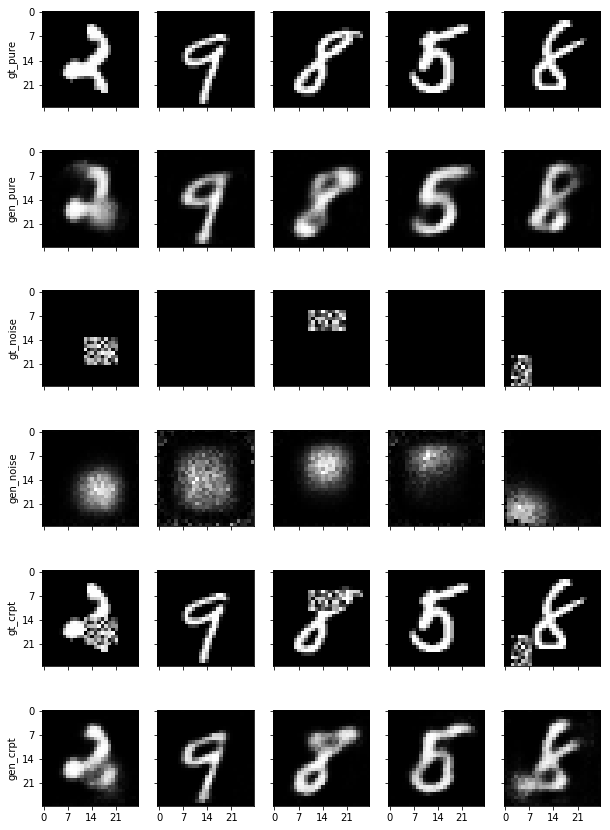

In [14]:
# Parameters
training_epochs = FLAGS.training_epochs
batch_size = FLAGS.batch_size
display_step = FLAGS.display_step
# Plot
n_plot = 5    # plot 5 images
train_disp_idx = np.random.randint(mnist.train.num_examples, size=n_plot)    # fixed during train time
test_disp_idx = np.random.randint(mnist.test.num_examples, size=n_plot)

# Initialize
sess = tf.Session(config=config)
sess.run(init)

# Optimize
for epoch in range(training_epochs):
    total_cost = 0.
    n_total_batch = int(mnist.train.num_examples/batch_size)
    rand_train_idx = np.random.randint(mnist.train.num_examples, size=batch_size)
    rand_test_idx = np.random.randint(mnist.test.num_examples, size=batch_size)
    
    # Iteration
    for i in range(n_total_batch):
        batch_pure, _ = mnist.train.next_batch(batch_size)    # pure image
        noise = noise_batch(batch_size)    # random noise
        batch_crpt = occl(batch_pure, noise)   # corrupted image 
        feeds = {ph_pure: batch_pure, ph_noise: noise, ph_crpt: batch_crpt}
        sess.run(optm, feed_dict=feeds)
        #total_cost += sess.run(loss, feed_dict=feeds)
    #total_cost = total_cost / mnist.train.num_examples
    
    train_pure = train_img[rand_train_idx]    # pure image
    train_noise = noise_batch(batch_size)    # random noise
    train_crpt = occl(train_pure,train_noise)   # corrupted image
    train_feeds = {ph_pure: train_pure, ph_noise: train_noise, ph_crpt: train_crpt}
    train_loss, tb_train_loss = sess.run([loss,_train_loss], feed_dict=train_feeds)
    
    test_pure = test_img[rand_test_idx]    # pure image
    test_noise = noise_batch(batch_size)    # random noise
    test_crpt = occl(test_pure,test_noise)   # corrupted image
    test_feeds = {ph_pure: test_pure, ph_noise: test_noise, ph_crpt: test_crpt}
    test_loss, tb_test_loss = sess.run([loss,_test_loss], feed_dict=test_feeds)

    writer.add_summary(tb_train_loss, epoch)
    writer.add_summary(tb_test_loss, epoch)
    print("Epoch : %03d/%03d  Train_loss : %.7f  Test_loss : %.7f" 
          % (epoch+1, training_epochs, train_loss, test_loss))   
        
    # Display
    if (epoch+1) % display_step == 0:
        train_gt_pure = train_img[train_disp_idx]    # pure image
        train_gt_noise = noise_batch(n_plot)    # random noise
        train_gt_crpt = occl(train_gt_pure,train_gt_noise)   # corrupted image
        train_gt_feeds = {ph_pure: train_gt_pure, ph_noise: train_gt_noise, ph_crpt: train_gt_crpt}
        
        test_gt_pure = test_img[test_disp_idx]    # pure image
        test_gt_noise = noise_batch(n_plot)    # random noise
        test_gt_crpt = occl(test_gt_pure,test_gt_noise)   # corrupted image
        test_gt_feeds = {ph_pure: test_gt_pure, ph_noise: test_gt_noise, ph_crpt: test_gt_crpt}
        
        # generated images
        train_gen_pure, train_gen_noise, train_gen_crpt = sess.run([core_gen, shell2_gen, full_gen], \
                                        feed_dict=train_gt_feeds)  # 784-d vector
        test_gen_pure, test_gen_noise, test_gen_crpt = sess.run([core_gen, shell2_gen, full_gen], \
                                        feed_dict=test_gt_feeds)  # 784-d vector
        
        # plotting results from training data
        fig, axes = plt.subplots(nrows=6, ncols=n_plot, figsize=(10,3*n_plot))   # displaying 4*n_plot images
        plt.setp(axes, xticks=np.arange(0,27,7), yticks=np.arange(0,27,7)) 
        for j in range(n_plot):
            train_disp_gt_pure = np.reshape(train_gt_pure[j], [28,28])
            axes[0, j].imshow(train_disp_gt_pure, cmap='gray')
            axes[0, j].set(ylabel='gt_pure')
            axes[0, j].label_outer()
            
            train_disp_gen_pure = np.reshape(train_gen_pure[j], [28,28])    # 28x28
            axes[1, j].imshow(train_disp_gen_pure, cmap='gray')   
            axes[1, j].set(ylabel='gen_pure')
            axes[1, j].label_outer()
            
            train_disp_gt_noise = np.reshape(train_gt_noise[j], [28,28])    # 28x28
            axes[2, j].imshow(train_disp_gt_noise, cmap='gray')   
            axes[2, j].set(ylabel='gt_noise')
            axes[2, j].label_outer()
            
            train_disp_gen_noise = np.reshape(train_gen_noise[j], [28,28])    # 28x28
            axes[3, j].imshow(train_disp_gen_noise, cmap='gray')   
            axes[3, j].set(ylabel='gen_noise')
            axes[3, j].label_outer()
            
            train_disp_gt_crpt = np.reshape(train_gt_crpt[j], [28,28])    # 28x28
            axes[4, j].imshow(train_disp_gt_crpt, cmap='gray')   
            axes[4, j].set(ylabel='gt_crpt')
            axes[4, j].label_outer()
            
            train_disp_gen_crpt = np.reshape(train_gen_crpt[j], [28,28])    # 28x28
            axes[5, j].imshow(train_disp_gen_crpt, cmap='gray')   
            axes[5, j].set(ylabel='gen_crpt')
            axes[5, j].label_outer()
            
                    
        plt.savefig(outputdir+'/train/epoch %03d' %(epoch))    
        plt.close(fig)
        
        # plotting results from testing data
        fig, axes = plt.subplots(nrows=6, ncols=n_plot, figsize=(10,3*n_plot))   # displaying 4*n_plot images
        plt.setp(axes, xticks=np.arange(0,27,7), yticks=np.arange(0,27,7)) 
        for k in range(n_plot):
            test_disp_gt_pure = np.reshape(test_gt_pure[k], [28,28])
            axes[0, k].imshow(test_disp_gt_pure, cmap='gray')
            axes[0, k].set(ylabel='gt_pure')
            axes[0, k].label_outer()
            
            test_disp_gen_pure = np.reshape(test_gen_pure[k], [28,28])    # 28x28
            axes[1, k].imshow(test_disp_gen_pure, cmap='gray')   
            axes[1, k].set(ylabel='gen_pure')
            axes[1, k].label_outer()
            
            test_disp_gt_noise = np.reshape(test_gt_noise[k], [28,28])    # 28x28
            axes[2, k].imshow(test_disp_gt_noise, cmap='gray')   
            axes[2, k].set(ylabel='gt_noise')
            axes[2, k].label_outer()
            
            test_disp_gen_noise = np.reshape(test_gen_noise[k], [28,28])    # 28x28
            axes[3, k].imshow(test_disp_gen_noise, cmap='gray')   
            axes[3, k].set(ylabel='gen_noise')
            axes[3, k].label_outer()
            
            test_disp_gt_crpt = np.reshape(test_gt_crpt[k], [28,28])    # 28x28
            axes[4, k].imshow(test_disp_gt_crpt, cmap='gray')   
            axes[4, k].set(ylabel='gt_crpt')
            axes[4, k].label_outer()
            
            test_disp_gen_crpt = np.reshape(test_gen_crpt[k], [28,28])    # 28x28
            axes[5, k].imshow(test_disp_gen_crpt, cmap='gray')   
            axes[5, k].set(ylabel='gen_crpt')
            axes[5, k].label_outer()
                    
        plt.savefig(outputdir+'/train/epoch %03d' %(epoch))    
        plt.close(fig)
        
        # Save
        if (epoch+1) % save_step ==0:
            savename = savedir+"/net-"+str(epoch+1)+".ckpt"
            saver.save(sess, savename)
            print("[%s] SAVED" % (savename))

print("Optimization Finished")